# Аутентификация по параметрам динамики простановки подписи на графическом планшете

## Импорт библиотек и загрузка данных

In [1]:
from IPython.display import clear_output

In [2]:
%pip install tensorflow
%pip install pydot
%pip install graphviz
clear_output()

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import pylab
pylab.rcParams['figure.figsize'] = (10, 5)
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

Зафиксируем сид генерации случайных чисел:

In [4]:
random_state = np.random.RandomState(5)

Загружаем сформированный ранее урезанный набор Small.csv, состоящий из 100 тыс. записей, отбираемых случайным образом из полного набора данных. Проверяем, что набор загрузился полностью.

In [5]:
data = np.loadtxt('Small.csv', delimiter=",")
data.shape

(100000, 289)

In [6]:
X = data[:, :-1]
y = data[:, -1]

Видим, что последний столбец - зависимая переменная, остальные столбцы - независимые переменные (параметры подписи).

## Метрики качества модели

In [7]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Разделение датасета

Разделим наш датасет на тестовую и обучающую выборки, которые соответственно будут использоваться в дальнейшем для непосредственного обучения модели и для оценки ее качества. Разделение проводим в соотношении 30% (тестовая выборка) на 70% (обучающая выборка).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state, stratify = y)

## Построение классификаторов

В данной работе рассмотрим построение различных классификаторов в рамках анализа набора данных для решения задачи классификации на 2 класса.
Рассматривать будем классификаторы, построенные на основе нейронной сети и на основе ансамблевых методов, так как именно эти модели выдали наилучший результат и быстродействие.

### Классификатор на основе нейронной сети

In [9]:
model = Sequential()
model.add(BatchNormalization(input_shape=(288,)))

model.add(Dense(288, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(288, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_m])

In [10]:
results = model.fit(X_train,y_train,validation_data = (X_test,y_test),batch_size = 1000,epochs=200)

Epoch 1/200
70/70 [==============================] - 3s 18ms/step - loss: 0.5365 - f1_m: 0.3303 - val_loss: 0.2820 - val_f1_m: 0.0000e+00
Epoch 2/200
70/70 [==============================] - 1s 15ms/step - loss: 0.2182 - f1_m: 0.6222 - val_loss: 0.2523 - val_f1_m: 0.0958
Epoch 3/200
70/70 [==============================] - 1s 15ms/step - loss: 0.1188 - f1_m: 0.7655 - val_loss: 0.1602 - val_f1_m: 0.4321
Epoch 4/200
70/70 [==============================] - 1s 15ms/step - loss: 0.0791 - f1_m: 0.8495 - val_loss: 0.0891 - val_f1_m: 0.7742
Epoch 5/200
70/70 [==============================] - 1s 15ms/step - loss: 0.0598 - f1_m: 0.8900 - val_loss: 0.0512 - val_f1_m: 0.8838
Epoch 6/200
70/70 [==============================] - 1s 15ms/step - loss: 0.0469 - f1_m: 0.9151 - val_loss: 0.0386 - val_f1_m: 0.9208
Epoch 7/200
70/70 [==============================] - 1s 15ms/step - loss: 0.0382 - f1_m: 0.9293 - val_loss: 0.0331 - val_f1_m: 0.9380
Epoch 8/200
70/70 [==============================] - 1s 15

In [11]:
f1_nn = results.history['val_f1_m'][-1]
np.round(f1_nn, 3)

0.987

Рассмотрим наглядно архитектуру данной нейронной сети:

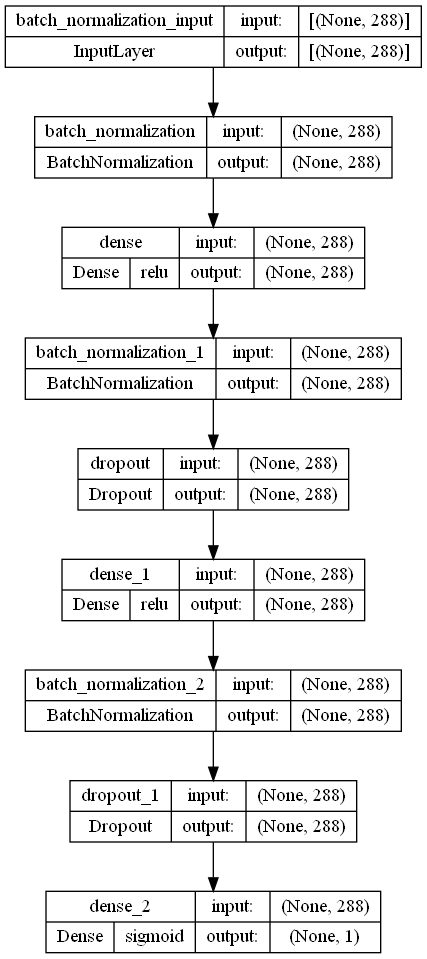

In [12]:
#требует установки graphviz на локальную машину
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_activations = True)

Отрисуем показатели точности и потерь построенной нейронной сети:

In [13]:
def display_f1_m():
    plt.plot(results.history['f1_m'])
    plt.plot(results.history['val_f1_m'])

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def display_loss():
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

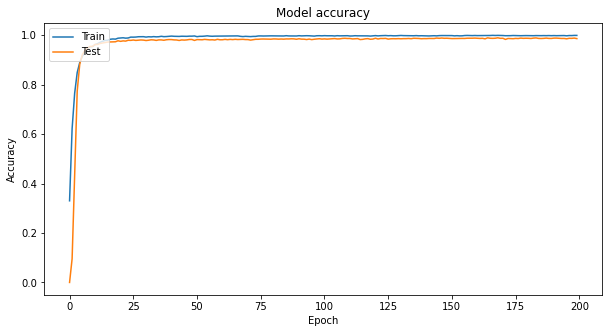

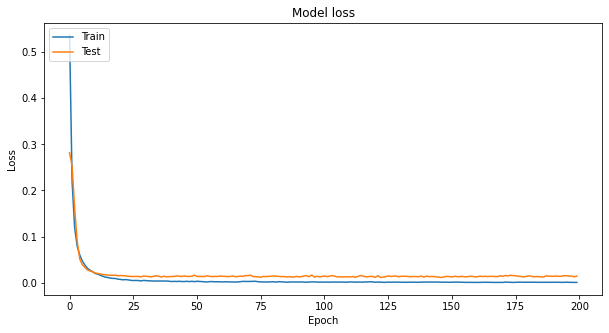

In [14]:
display_f1_m()
display_loss()

Построенный классификатор достаточно хорошо выполняет поставленную задачу, значение F-меры = 0.987.

### Классификатор на основе Gradient Tree Boosting (градиентый бустинг)

Оптимальные параметры для данного классификатора были получены с помощью платформы для анализа данных RapidMiner. Автомоделирование методом Gradient Tree Boosting на нашем наборе данных показало наилучший результат (значение F-меры 98.2%) при следующих параметрах:
*  количество деревьев - 150;
*  максимальная глубина - 7;
*  скорость обучения - 0.1.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(random_state = random_state, learning_rate = 0.1, n_estimators = 150, max_depth = 7)
model_gb.fit(X_train, y_train)
f1_gb = f1_m(y_test, np.round(model_gb.predict_proba(X_test)[:, 1]))
f1_gb.numpy()

0.9328222216470101

In [30]:
predictions_gb = model_gb.predict(X_test)
print (classification_report(y_test, predictions_gb))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     27386
         1.0       0.99      0.88      0.93      2614

    accuracy                           0.99     30000
   macro avg       0.99      0.94      0.96     30000
weighted avg       0.99      0.99      0.99     30000



Построенный классификатор также хорошо выполняет поставленную задачу, значение F-меры = 0.933.

### Классификатор на основе Adaptive Boosting (адаптивный бустинг)

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

parameters = {'base_estimator__max_depth':[5,6,7,8],
              'n_estimators':[150,200,250,300]
              }

adc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

model_ad = RandomizedSearchCV(adc, parameters,n_iter=5, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state), random_state=random_state, scoring='f1',n_jobs=-1)
model_ad.fit(X_train,y_train)

print('Best params', model_ad.best_params_)
print('Best score', model_ad.best_score_)

Best params {'n_estimators': 200, 'base_estimator__max_depth': 5}
Best score 0.8643370588592768


In [18]:
f1_ad = f1_m(y_test, np.round(model_ad.predict_proba(X_test)[:, 1]))
f1_ad.numpy()

0.907110513330275

In [31]:
predictions_ad = model_ad.predict(X_test)
print (classification_report(y_test, predictions_ad))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     27386
         1.0       0.98      0.84      0.91      2614

    accuracy                           0.98     30000
   macro avg       0.98      0.92      0.95     30000
weighted avg       0.98      0.98      0.98     30000



С помощью рандомизированного поиска были подобраны следующие параметры для модели адаптивного бустинга, при которых значение F-меры получилось равным 0.907:
*  количество деревьев - 200;
*  максимальная глубина - 5.

Классификатор дает неплохой результат, что подтверждается значением F-меры и матрицей неточности, однако возможно будет достигнут лучший результат при применении поиска по сетке, который требует значительно больших вычислительных ресурсов и затрат времени (особенно при расширении пространства параметров, в том числе использование другого базового алгоритма вместо деревьев решений).

## Итоговая оценка

In [28]:
print(f1_nn, f1_gb.numpy(), f1_ad.numpy())
print("Средняя f1 мера составляет", ((f1_nn+f1_gb+f1_ad)/3).numpy())
print("Количество баллов равно", max(min(22,(f1_nn*100+f1_gb*100+f1_ad*100)/3-75),0).numpy())

0.9865158200263977 0.9328222216470101 0.907110513330275
Средняя f1 мера составляет 0.9421495183345611
Количество баллов равно 19.214951833456098
